In [1]:
# ==========
# Original paper
# ==========
#!/usr/bin/python3
# -*- coding: utf-8 -*-

"""
Plain deep2BSDE solver with hard-coded Allen-Cahn equation
"""

import tensorflow as tf
import numpy as np
import time, datetime

In [2]:
# ==========
# Original paper
# ==========
tf.compat.v1.reset_default_graph()
start_time = time.time()

name = 'AllenCahn'

# setting of the problem
d = 20
T = 0.3
Xi = np.zeros([1,d])

# setup of algorithm and implementation
N = 20
h = T/N
sqrth = np.sqrt(h)
n_maxstep = 10000
batch_size = 1
gamma = 0.001

# neural net architectures
n_neuronForGamma = [d, d, d, d**2]
n_neuronForA = [d, d, d, d]

1. `d`：dimension of the input and all the hidden layers, in fact, the discrete time range
2. `T`：
3. `Xi`：
4. `N`：
5. `h`：
6. `sqrth`：
7. `n_maxstep`：
8. `batch_size`：
9. `gamma`：

![](https://cdn.mathpix.com/snip/images/SDQXv9SnmJja4aSBKziYGHt6fqzX0De68toYycGc4A0.original.fullsize.png)

10. `n_neuronForGamma`：
11. `n_neuronForA`：

In [3]:
# ==========
# Original paper
# ==========
# (adapted) rhs of the pde
def f0(t,X,Y,Z,Gamma):
    return -Y+tf.pow(Y, 3)

$$
f_0(t,X,Y,Z,\Gamma)=-Y+Y^3
$$

In [4]:
# ==========
# Original paper
# ==========
# terminal condition
def g(X):
    return 1/(1 + 0.2*tf.reduce_sum(tf.square(X), 1, keepdims=True))*0.5

$$
g(x)=\frac{1}{1+0.2}
$$

In [5]:
# ==========
# Original paper
# ==========
# helper functions for constructing the neural net(s)
def _one_time_net(x, name, isgamma = False):
    with tf.compat.v1.variable_scope(name):
        layer1 = _one_layer(x, (1-isgamma)*n_neuronForA[1]+isgamma*n_neuronForGamma[1], name = 'layer1')
        layer2 = _one_layer(layer1, (1-isgamma)*n_neuronForA[2]+isgamma*n_neuronForGamma[2], name = 'layer2')
        z = _one_layer(layer2, (1-isgamma)*n_neuronForA[3]+isgamma*n_neuronForGamma[3], activation_fn=None,name = 'final')
        return z

`isgamma=True`: `n_neuronForGamma`

`isgamma=False`: `n_neuronForA`

![](https://cdn.mathpix.com/snip/images/SDQXv9SnmJja4aSBKziYGHt6fqzX0De68toYycGc4A0.original.fullsize.png)


In [6]:
# ==========
# Original paper
# ==========
def _one_layer(input_, output_size, activation_fn=tf.nn.relu, stddev=5.0, name='linear'):
    # defining operations for this certain layer
    with tf.compat.v1.variable_scope(name):
        shape = input_.get_shape().as_list()
        # initialize the weight matrix by normal distribution
        w = tf.compat.v1.get_variable('Matrix', [shape[1], output_size], tf.float64, tf.random_normal_initializer(stddev=stddev/np.sqrt(shape[1]+output_size)))
        # initialize the bias vector to all 0
        b = tf.compat.v1.get_variable('Bias', [1,output_size], tf.float64, tf.constant_initializer(0.0))
        # h=wx+b
        hidden = tf.matmul(input_, w) + b
        # If the activation function exists, we add the activation layer, otherwise not
        if activation_fn:
            return activation_fn(hidden)
        else:
            return hidden

tf.Tensor(20, shape=(), dtype=int32)
[1, 20]
[20, 20]
[1, 20]


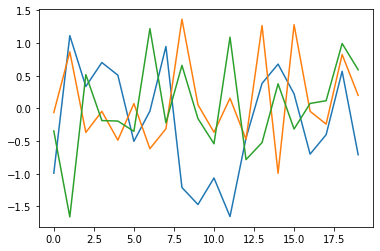

In [30]:
# ==========
# Test case
# ==========
X_test = tf.Variable(np.ones([batch_size, d]) * Xi, dtype = tf.float64, name='X', trainable=False)
print(tf.size(X_test))
shape_test = X_test.get_shape().as_list()
print(shape_test)
# The shape is the WEIGHT matrix, w
print([shape_test[1], 20])
# The shape is the BIAS vector, b
print([1, 20])
w_test = tf.compat.v1.get_variable('Matrix', [shape_test[1], 20], tf.float64, tf.random_normal_initializer(stddev=5.0/np.sqrt(shape_test[1]+20)))
plt.plot(w_test[0])
plt.plot(w_test[1])
plt.plot(w_test[2])


In [8]:
# ==========
# Original paper
# ==========
with tf.compat.v1.Session() as sess:
    # background dynamics
    dW = tf.random.normal(shape=[batch_size, d], stddev = sqrth, dtype=tf.float64)

    # initial values of the stochastic processes
    X = tf.Variable(np.ones([batch_size, d]) * Xi, dtype = tf.float64, name='X', trainable=False)
    Y0 = tf.Variable(tf.random.uniform([1], minval = -1, maxval = 1, dtype=tf.float64), name='Y0')
    Z0 = tf.Variable(tf.random.uniform([1,d], minval = -.1, maxval = .1, dtype=tf.float64), name='Z0')
    Gamma0 = tf.Variable(tf.random.uniform([d, d], minval = -.1, maxval = .1, dtype=tf.float64), name='Gamma0')
    A0 = tf.Variable(tf.random.uniform([1,d], minval = -.1, maxval = .1, dtype=tf.float64), name='A0')
    allones = tf.ones(shape=[batch_size, 1], dtype=tf.float64, name='MatrixOfOnes')
    Y = allones * Y0
    Z = tf.matmul(allones,Z0)
    Gamma = tf.multiply(tf.ones([batch_size, d, d], dtype = tf.float64), Gamma0)
    A = tf.matmul(allones,A0)
    
    
    # forward discretization
    with tf.compat.v1.variable_scope('forward'):
        for i in range(N-1):
            Y=Y+f0(i*h,X,Y,Z,Gamma)*h + tf.reduce_sum(dW*Z, 1, keepdims=True)
            Z=Z+A*h + tf.squeeze(tf.matmul(Gamma, tf.expand_dims(dW, -1)))
            Gamma = tf.reshape(_one_time_net(X, name=str(i)+'Gamma', isgamma=True)/d**2, [batch_size, d, d])
        
            if i!=N-1:
                A = _one_time_net(X, name=str(i)+'A')/d
            X = X + dW
            dW = tf.random.normal(shape=[batch_size, d], stddev = sqrth, dtype=tf.float64)
        
        Y = Y + f0( (N-1)*h , X,Y,Z,Gamma)*h + tf.reduce_sum(dW*Z, 1, keepdims=True)
        X = X + dW
        loss_function = tf.reduce_mean(tf.square(Y-g(X)))
    
    
    # specifying the optimizer
    global_step = tf.compat.v1.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False, dtype=tf.int32)
    
    learning_rate = tf.compat.v1.train.exponential_decay(gamma, global_step, decay_steps = 10000, decay_rate = 0.0, staircase = True)
    
    
    trainable_variables = tf.compat.v1.trainable_variables()
    grads = tf.gradients(loss_function, trainable_variables)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
    apply_op = optimizer.apply_gradients(zip(grads, trainable_variables),global_step=global_step, name='train_step')

    with tf.control_dependencies([apply_op]):
        train_op_2 = tf.identity(loss_function, name='train_op2')


    # to save history
    learning_rates = []
    y0_values = []
    losses = []
    running_time = []
    steps = []
    sess.run(tf.compat.v1.global_variables_initializer())
    
    
    try:
        # the actual training loop
        for _ in range(n_maxstep + 1):
            y0_value, step = sess.run([Y0, global_step])
            currentLoss, currentLearningRate = sess.run([train_op_2, learning_rate])

            learning_rates.append(currentLearningRate)
            losses.append(currentLoss)
            y0_values.append(y0_value)
            running_time.append(time.time()-start_time)
            steps.append(step)

            if step % 100 == 0:
                print("step: ", step,
                          " loss: ", currentLoss,
                          " Y0: " , y0_value,
                          " learning rate: ", currentLearningRate)

        end_time = time.time()
        print("running time: ", end_time-start_time)

    except KeyboardInterrupt:
        print("\nmanually disengaged")

step:  0  loss:  0.112377752479629  Y0:  [-0.34955844]  learning rate:  0.001
step:  100  loss:  0.34926280040499286  Y0:  [-0.27287906]  learning rate:  0.001
step:  200  loss:  0.08293380567072467  Y0:  [-0.20678064]  learning rate:  0.001
step:  300  loss:  0.10626124072871486  Y0:  [-0.1493461]  learning rate:  0.001
step:  400  loss:  0.00018655675373675657  Y0:  [-0.1010374]  learning rate:  0.001
step:  500  loss:  0.19558073306291415  Y0:  [-0.05738137]  learning rate:  0.001
step:  600  loss:  0.043715593798287884  Y0:  [-0.01681032]  learning rate:  0.001
step:  700  loss:  0.03393213634218902  Y0:  [0.01948263]  learning rate:  0.001
step:  800  loss:  0.01069051979515808  Y0:  [0.04970339]  learning rate:  0.001
step:  900  loss:  5.792381326070775e-05  Y0:  [0.08035186]  learning rate:  0.001
step:  1000  loss:  0.02579529507738129  Y0:  [0.10455918]  learning rate:  0.001
step:  1100  loss:  3.899073015690406e-06  Y0:  [0.12401417]  learning rate:  0.001
step:  1200  loss

step:  9900  loss:  0.012869159306051767  Y0:  [0.3066793]  learning rate:  0.001
step:  10000  loss:  0.02590387549509981  Y0:  [0.30932651]  learning rate:  0.0
running time:  40.64858865737915


In [9]:
# ==========
# Original paper
# ==========
# writing results to a csv file
output = np.zeros((len(y0_values), 5))
output[:,0] = steps
output[:,1] = losses
output[:,2] = y0_values
output[:,3] = learning_rates
output[:,4] = running_time

In [10]:
# ==========
# Importing
# ==========
import matplotlib.pyplot as plt

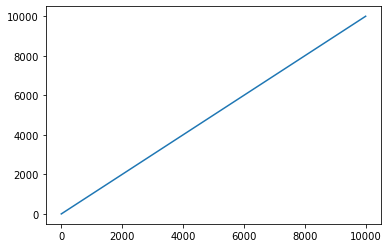

In [11]:
# ==========
# Plot graph
# ==========
plt.plot(steps)

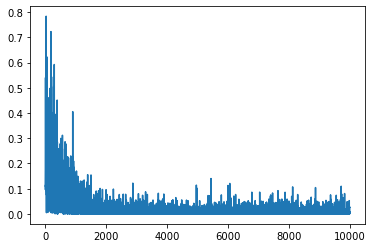

In [12]:
# ==========
# Plot graph
# ==========
plt.plot(losses)

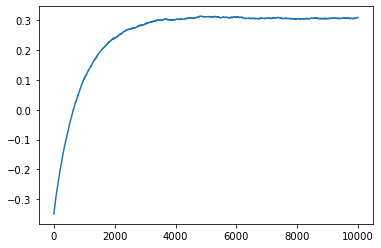

In [13]:
# ==========
# Plot graph
# ==========
plt.plot(y0_values)

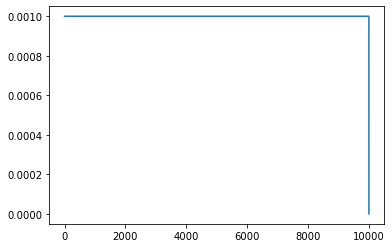

In [14]:
# ==========
# Plot graph
# ==========
plt.plot(learning_rates)

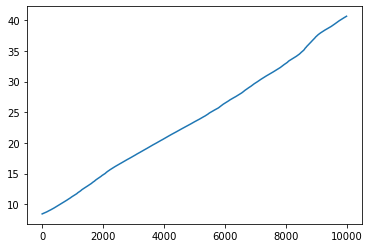

In [15]:
# ==========
# Plot graph
# ==========
plt.plot(running_time)

In [19]:
tf.Graph()